In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
print(chars)
stoi = {s:i+1 for i,s in enumerate(chars)}
print(stoi)
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
C = torch.randn((27, 2))

In [32]:
emb = C[X]
print(emb.shape)
print(X.shape)

torch.Size([228146, 3, 2])
torch.Size([228146, 3])


In [30]:
F.one_hot(torch.tensor(4), num_classes=27)

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [33]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [35]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [39]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

In [40]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [42]:
print(h.shape)
h

torch.Size([228146, 100])


tensor([[-0.7832,  0.9993,  0.8371,  ..., -0.0816,  0.9990, -0.5911],
        [ 0.7563,  1.0000, -0.9678,  ..., -0.8730,  0.9932, -0.3913],
        [-0.9891,  0.9966,  0.9971,  ..., -0.8201,  0.9991, -0.9808],
        ...,
        [ 0.8595,  0.9759,  0.9969,  ...,  0.5897,  0.9978,  0.7400],
        [-0.4018,  0.9509, -0.8995,  ...,  0.0714,  0.9887, -0.8548],
        [-0.9663,  0.9995,  0.5677,  ...,  0.7155,  0.9979, -0.9985]])

In [16]:
h.shape

torch.Size([228146, 100])

In [43]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [44]:
logits = h @ W2 + b2

In [45]:
logits.shape

torch.Size([228146, 27])

In [46]:
counts = logits.exp()
print(len(counts))
print(len(counts.sum(1, keepdims=True)))

228146
228146


In [47]:
prob = counts / counts.sum(1, keepdims=True)

In [48]:
prob.shape

torch.Size([228146, 27])

In [49]:
Y.shape

torch.Size([228146])

In [50]:
loss = -prob[torch.arange(228146), Y].log().mean()
loss

tensor(16.6657)

In [51]:
# ------------ now made respectable :) ---------------

In [52]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [53]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [54]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [55]:
for p in parameters:
  p.requires_grad = True

In [56]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [57]:
lri = []
lossi = []
stepi = []

In [58]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

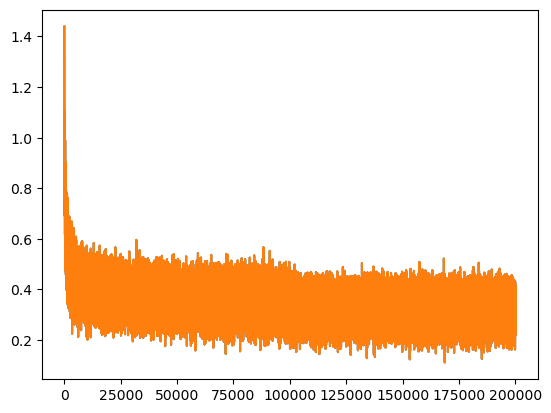

In [60]:
plt.plot(stepi, lossi)
plt.show()

In [61]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1259, grad_fn=<NllLossBackward0>)

In [62]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1657, grad_fn=<NllLossBackward0>)

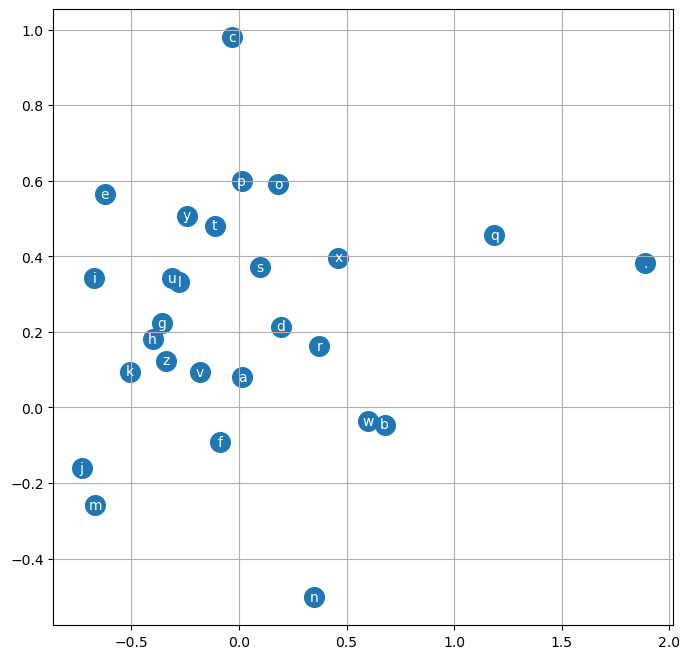

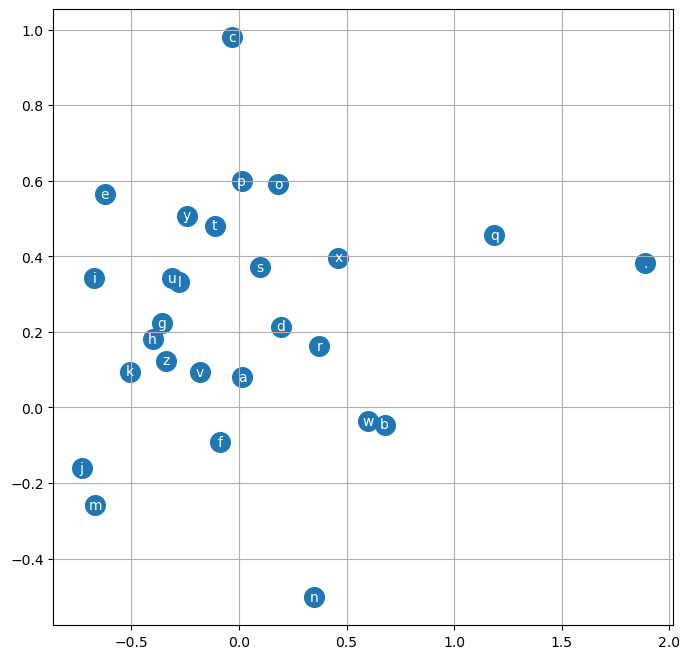

In [64]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

In [65]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [66]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [67]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
kayah.
keel.
ndyn.
alayzier.
jengrlee.
adelynnelin.
shyonelle.
elisson.
artelleima.
kalin.
shubrigahiriel.
kindo.
jennox.
terianu.
zayven.
kylene.
els.
kaysh.
skylanihan.
